Expected rows: 3680641
            timestamp    float_1    float_2   float_3    float_4  int_1  \
0 2020-01-01 00:00:00  14.830987  15.723351  7.764221   9.139441    8.0   
1 2020-01-01 00:01:00  15.277334  14.383782  8.050471   9.241592    9.0   
2 2020-01-01 00:02:00  14.407419  14.133512  7.785035  11.045418    8.0   
3 2020-01-01 00:03:00  14.416103  14.438385  7.607109   8.510004    9.0   
4 2020-01-01 00:04:00  15.331454  13.149238  8.170057   8.315616    8.0   

   int_2  int_3  int_4  
0    7.0    8.0    8.0  
1    7.0    8.0    8.0  
2    7.0    9.0    9.0  
3    7.0    9.0    9.0  
4    7.0    9.0    8.0  
Generated 3680641 rows in 12.31 seconds


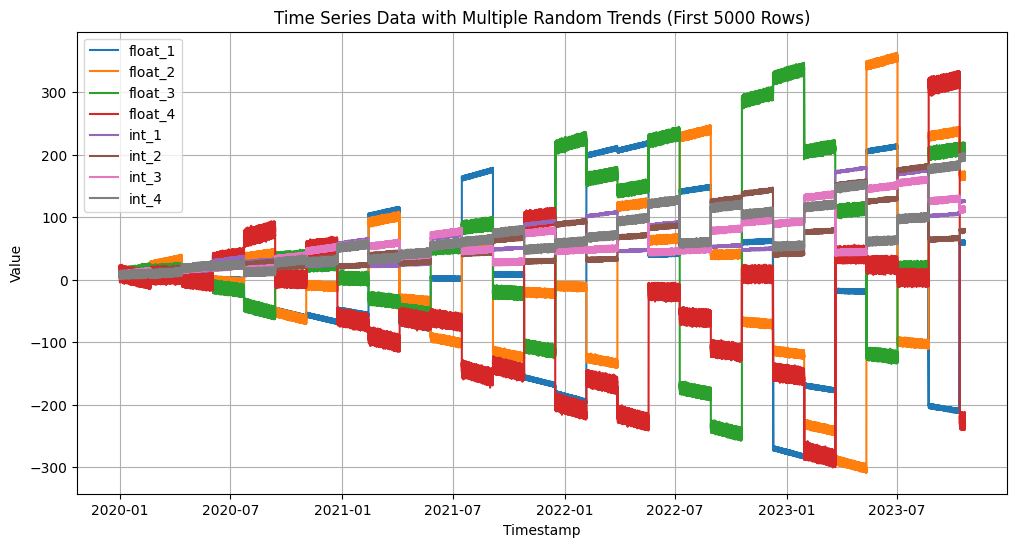

In [88]:
import pandas as pd
import numpy as np
import time

# 设置随机种子以确保可重复性
np.random.seed(42)

# 设置时间范围和参数
start_date = "2020-01-01"
end_date = "2026-12-31"  # 约 10 年
freq = "min"  # 每分钟采样
date_range = pd.date_range(start=start_date, end=end_date, freq=freq)

# 验证行数
num_rows = len(date_range)
print(f"Expected rows: {num_rows}")  # 10 年 * 365 天 * 24 小时 * 60 分钟 ≈ 5,256,000 行

# 定义列数和趋势段数
num_float_cols = 4
num_int_cols = 4
num_segments = 50  # 每个列分成 50 段不同趋势

# 初始化 DataFrame
df = pd.DataFrame({"timestamp": date_range})

# 记录开始时间
start_time = time.time()

# 计算每个趋势段的长度（尽量均匀）
segment_length = num_rows // num_segments
segment_boundaries = [i * segment_length for i in range(num_segments)] + [num_rows]

# 生成时间点（分钟为单位，用于正弦信号）
t = np.arange(num_rows)

# 生成浮点数时间序列
for i in range(1, num_float_cols + 1):
    # 初始化列
    values = np.zeros(num_rows)
    # 为每个段生成不同趋势
    for j in range(num_segments):
        start_idx = segment_boundaries[j]
        end_idx = segment_boundaries[j + 1]
        # 随机生成线性趋势参数
        coef = np.random.uniform(-0.0002, 0.0002)  # 随机斜率
        offset = np.random.uniform(5.0, 15.0)  # 随机截距
        # 正弦信号 + 随机线性趋势 + 高斯噪声
        sinusoidal = 2.0 * i * np.sin(2 * np.pi * t[start_idx:end_idx] / 1440)
        trend = offset + coef * t[start_idx:end_idx]
        noise = np.random.normal(0, 0.5 * i, end_idx - start_idx)
        values[start_idx:end_idx] = sinusoidal + trend + noise
    df[f"float_{i}"] = values

# 生成整数时间序列
for i in range(1, num_int_cols + 1):
    values = np.zeros(num_rows)
    for j in range(num_segments):
        start_idx = segment_boundaries[j]
        end_idx = segment_boundaries[j + 1]
        coef = np.random.uniform(0.00002, 0.0001)  # 随机斜率（较小）
        offset = np.random.uniform(3.0, 10.0)  # 随机截距
        sinusoidal = 1.0 * i * np.sin(2 * np.pi * t[start_idx:end_idx] / 1440)
        trend = offset + coef * t[start_idx:end_idx]
        noise = np.random.normal(0, 0.2 * i, end_idx - start_idx)
        values[start_idx:end_idx] = np.round(sinusoidal + trend + noise).astype(int)
    df[f"int_{i}"] = values

# 保存到 CSV 文件
output_file = "../../data/synthesis_data.csv"
df.to_csv(output_file, index=False)

# 打印前几行和执行时间
print(df.head())
print(f"Generated {len(df)} rows in {time.time() - start_time:.2f} seconds")

# 可视化前 5000 行（显示多段趋势）
import matplotlib.pyplot as plt
print_range = 2000000
plt.figure(figsize=(12, 6))
for col in df.columns:
    if col.startswith("float_") or col.startswith("int_"):
        plt.plot(df["timestamp"][:print_range], df[col][:print_range], label=col)
plt.legend()
plt.title("Time Series Data with Multiple Random Trends (First 5000 Rows)")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.grid(True)
plt.show()